1. run all models - extract val and test set
2. do mean of val and test set

In [1]:
import pandas as pd
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator
import numpy as np

from torch_geometric.data import DataLoader
from tqdm import tqdm
import torch

import os

Using backend: pytorch


In [2]:
"""
LOAD HYPERPARAMETERS
"""
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.device = 0

shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}

device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
# device = "cpu"

## load data

In [3]:
"""
LOAD DATA
"""
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()

valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
print(len(split_idx["train"]), len(split_idx["test"]), len(split_idx["valid"]))

3045360 377423 380670


In [4]:
def get_prediction(model, loader):
    y_true = []
    y_pred = []
    for step, batch in enumerate(tqdm(loader, desc="Iteration")):

        # put batch to cuda
        batch = batch.to(device)

        pred = model(batch)
        pred = pred.view(-1)    
        # collate prediction
        pred_np = pred.detach().cpu().numpy()
        y_pred.extend(pred_np)

        # collate label
        label = batch.y.detach().cpu().numpy()
        y_true.extend(label)
        
    return y_true, y_pred

## pygeom models

In [8]:
from gnn import GNN, BayesianGNN

In [9]:
def loadPyGeomModel(modelName, gnn_name, gnn_type, virtual_node, checkpoint_dir, modelType):
    """
    LOAD Checkpoint data
    """
    checkpoint = torch.load(os.path.join(checkpoint_dir, 'checkpoint.pt'))

    model = modelType(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
    model.load_state_dict(checkpoint["model_state_dict"], strict=True)
    model.state_dict()
    # set model to evaluation-only
    model.eval()
    print(modelName, checkpoint["best_val_mae"])

    """
    get prediction for val
    """
    y_true, val_pred = get_prediction(model, valid_loader)    
    evaluator = PCQM4MEvaluator()
    input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(val_pred)}
    print(modelName, evaluator.eval(input_dict)["mae"])

    # save results to dataframe
    valDF = pd.DataFrame(zip(split_idx["valid"].cpu().tolist(), y_true, val_pred), columns=["molecule_idx", "label", "pred"])

    """
    get prediction for test
    """
    _, test_pred = get_prediction(model, test_loader)  
    test_pred = np.array(test_pred)
    
    return modelName, valDF, test_pred

In [10]:
ginBNNModelName, ginBNNDF, ginBNN_test_pred = loadPyGeomModel("gin-virtual-bnn-lastLayer", "gin-virtual-bnn-lastLayer", "gin", True, "models/gin-virtual-bnn-lastLayer/checkpoint", BayesianGNN)

Iteration:   0%|                                                                              | 0/1487 [00:00<?, ?it/s]

gin-virtual-bnn-lastLayer 0.14056678116321564


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [02:02<00:00, 12.10it/s]


gin-virtual-bnn-lastLayer 0.14056038856506348


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [02:05<00:00, 11.78it/s]


In [11]:
ginBNNRun2ModelName, ginBNNRun2DF, ginBNN_run2_test_pred = loadPyGeomModel("gin-virtual-bnn-lastLayer-run2", "gin-virtual-bnn-lastLayer", "gin", True, "models/gin-virtual-bnn-lastLayer-run2/checkpoint", BayesianGNN)

Iteration:   0%|                                                                      | 2/1487 [00:00<01:35, 15.51it/s]

gin-virtual-bnn-lastLayer-run2 0.14187973737716675


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:35<00:00, 15.65it/s]


gin-virtual-bnn-lastLayer-run2 0.14188283681869507


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [01:38<00:00, 14.94it/s]


In [12]:
ginModelName, ginDF, gin_test_pred = loadPyGeomModel("gin-virtual", "gin-virtual", "gin", True, "models/gin-virtual/checkpoint", GNN)

Iteration:   0%|                                                                      | 2/1487 [00:00<01:37, 15.26it/s]

gin-virtual 0.14212889969348907


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:33<00:00, 15.88it/s]


gin-virtual 0.14212889969348907


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [01:38<00:00, 14.96it/s]


In [13]:
ginRun2ModelName, ginRun2DF, gin_run2_test_pred = loadPyGeomModel("gin-virtual-run2", "gin-virtual", "gin", True, "models/gin-virtual-run2-aaron/checkpoint", GNN)

Iteration:   0%|                                                                      | 2/1487 [00:00<01:34, 15.74it/s]

gin-virtual-run2 0.14319077134132385


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:34<00:00, 15.80it/s]


gin-virtual-run2 0.14319078624248505


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [01:36<00:00, 15.23it/s]


In [14]:
ginRun3ModelName, ginRun3DF, gin_run3_test_pred = loadPyGeomModel("gin-virtual-run3", "gin-virtual", "gin", True, "models/gin-virtual-run3-xavier/checkpoint", GNN)

Iteration:   0%|                                                                      | 2/1487 [00:00<01:35, 15.62it/s]

gin-virtual-run3 0.15115168690681458


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:33<00:00, 15.93it/s]


gin-virtual-run3 0.15115168690681458


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [01:38<00:00, 14.95it/s]


## load dgl models

In [5]:
def loadDGLModel(modelName, valFilename, testFilename, zip=False):
    valDF = pd.read_csv(valFilename)
    if testFilename is None:
        test_pred = None
    else:
        with open(testFilename, "rb") as f:
            test_pred = np.load(f)
            
            if zip:
                test_pred = test_pred["y_pred"]
            
    return modelName, valDF, test_pred

In [6]:
# DiffPool
ginDiffPoolModelName, ginDiffPoolDF, ginDiffPool_test_pred = loadDGLModel(
    "gin-virtual-diffpool", 
    "../pcqm4m-dgl/models/gin-virtual-diffpool/gin-virtual-diffPool-validResult.csv",
    "../pcqm4m-dgl/models/gin-virtual-diffpool/gin-virtual-diffpool-testResult.npy"
)
ginDiffPoolDF.rename({"gin-diffpool-pred": "pred"}, inplace=True, axis=1)

# DiffPool with 8 supervertices
ginDiffPool8ModelName, ginDiffPool8DF, ginDiffPool8_test_pred = loadDGLModel(
    "gin-virtual-diffpool-8", 
    "../pcqm4m-dgl/models/gin-virtual-diffpool-8/gin-virtual-diffPool-8-validResult.csv",
    "../pcqm4m-dgl/models/gin-virtual-diffpool-8/gin-virtual-diffpool-8-testResult.npy"
)
ginDiffPool8DF.rename({"gin-diffpool-pred": "pred"}, inplace=True, axis=1)

# DiffPool run 2
ginDiffPoolRun2ModelName, ginDiffPoolRun2DF, ginDiffPoolRun2_test_pred = loadDGLModel(
    "gin-virtual-diffpool-run2", 
    "../pcqm4m-dgl/models/gin-virtual-diffpool-run2/gin-virtual-diffPool-run2-validResult.csv",
    "../pcqm4m-dgl/models/gin-virtual-diffpool-run2/gin-virtual-diffpool-run2-testResult.npy"
)
ginDiffPoolRun2DF.rename({"gin-diffpool-pred": "pred"}, inplace=True, axis=1)

# DiffPool run 3
ginDiffPoolRun3ModelName, ginDiffPoolRun3DF, ginDiffPoolRun3_test_pred = loadDGLModel(
    "gin-virtual-diffpool-run3", 
    "../pcqm4m-dgl/models/gin-virtual-diffpool-run3/gin-virtual-diffPool-run3-validResult.csv",
    "../pcqm4m-dgl/models/gin-virtual-diffpool-run3/gin-virtual-diffpool-run3-testResult.npy"
)
ginDiffPoolRun3DF.rename({"gin-diffpool-pred": "pred"}, inplace=True, axis=1)


In [7]:
# DiffPool run kamil
ginDiffPoolKamilModelName, ginDiffPoolKamilDF, ginDiffPoolKamil_test_pred = loadDGLModel(
    "gin-virtual-diffpool-kamil", 
    "models/gin-virtual-diffpool-kamil/diffpool_valid.csv",
    "models/gin-virtual-diffpool-kamil/y_pred_pcqm4m.npz",
    True
)


## ensembling

In [15]:
ginDF.head()

,molecule_idx,label,pred
0,3045360,4.870838,4.860394
1,3045361,5.322547,5.343346
2,3045362,5.240913,4.994455
3,3045363,5.227307,5.107187
4,3045364,4.868117,5.044456


In [16]:
ginRun2DF.head()

,molecule_idx,label,pred
0,3045360,4.870838,4.855130
1,3045361,5.322547,5.303571
2,3045362,5.240913,4.976478
3,3045363,5.227307,5.126363
4,3045364,4.868117,5.024355


In [17]:
ginRun3DF.head()

,molecule_idx,label,pred
0,3045360,4.870838,4.832635
1,3045361,5.322547,5.351560
2,3045362,5.240913,5.050710
3,3045363,5.227307,5.112179
4,3045364,4.868117,5.013203


In [18]:
ginBNNDF.head()

,molecule_idx,label,pred
0,3045360,4.870838,4.825333
1,3045361,5.322547,5.324842
2,3045362,5.240913,5.103709
3,3045363,5.227307,5.182791
4,3045364,4.868117,5.028386


In [19]:
ginBNNRun2DF.head()

,molecule_idx,label,pred
0,3045360,4.870838,4.846446
1,3045361,5.322547,5.334028
2,3045362,5.240913,5.081901
3,3045363,5.227307,5.176788
4,3045364,4.868117,4.956361


In [20]:
ginDiffPoolDF.head()

,Unnamed: 0,molecule_idx,label,pred
0,0,3045360,4.870838,4.857602
1,1,3045361,5.322547,5.303278
2,2,3045362,5.240913,5.092427
3,3,3045363,5.227307,5.085762
4,4,3045364,4.868117,5.007533


In [21]:
ginDiffPoolRun2DF.head()

,Unnamed: 0,molecule_idx,label,pred
0,0,3045360,4.870838,4.864157
1,1,3045361,5.322547,5.341830
2,2,3045362,5.240913,5.151256
3,3,3045363,5.227307,5.208165
4,4,3045364,4.868117,5.012193


In [22]:
ginDiffPoolRun3DF.head()

,Unnamed: 0,molecule_idx,label,pred
0,0,3045360,4.870838,4.893821
1,1,3045361,5.322547,5.331312
2,2,3045362,5.240913,5.159584
3,3,3045363,5.227307,5.216216
4,4,3045364,4.868117,5.020232


In [23]:
ginDiffPoolKamilDF.head()

,molecule_idx,pred
0,3045360,4.863190
1,3045361,5.343327
2,3045362,5.015188
3,3045363,5.146418
4,3045364,4.963669


In [110]:
"""
get all values
"""
dictVals = {
    1: (ginModelName, ginDF["pred"], gin_test_pred),
    2: (ginRun2ModelName, ginRun2DF["pred"], gin_run2_test_pred),
    3: (ginRun3ModelName, ginRun3DF["pred"], gin_run3_test_pred),
    4: (ginBNNModelName, ginBNNDF["pred"], ginBNN_test_pred),
    5: (ginBNNRun2ModelName, ginBNNRun2DF["pred"], ginBNN_run2_test_pred),
    6: (ginDiffPoolModelName, ginDiffPoolDF["pred"], ginDiffPool_test_pred),
    7: (ginDiffPoolRun2ModelName, ginDiffPoolRun2DF["pred"], ginDiffPoolRun2_test_pred),
    8: (ginDiffPoolRun3ModelName, ginDiffPoolRun3DF["pred"], ginDiffPoolRun3_test_pred),
    9: (ginDiffPool8ModelName, ginDiffPool8DF["pred"], ginDiffPool8_test_pred),
    10: (ginDiffPoolKamilModelName, ginDiffPoolKamilDF["pred"], ginDiffPoolKamil_test_pred)
}

label = ginDF["label"]

In [98]:
from importlib import reload 
import tqdm
reload(tqdm)
from tqdm.notebook import tqdm

In [99]:
"""
find the best pair
"""
from itertools import chain, combinations

def getPowerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

def calcMAE(pairIndex, dictVals, label):
    if len(pairIndex) == 0:
        return np.float64("inf")
    
    # get raw time series
    pairs = [dictVals[x][1] for x in pairIndex]
    
    mean_pred = np.mean(list(zip(*pairs)), axis=1)
    evaluator = PCQM4MEvaluator()
    input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
    score = evaluator.eval(input_dict)["mae"]
    return score

powerset = getPowerset(dictVals.keys())

# calculate score
print("calculating score")
setScores = [(x, calcMAE(x, dictVals, label)) for x in tqdm(powerset)]

# find minimum
minVal = np.float64("inf")
minIndex = -1
for index, score in setScores:
    if score < minVal:
        minIndex = index
        minVal = score
        
# print best model
bestModel = [dictVals[x][0] for x in minIndex]

minIndex, bestModel, minVal

calculating score


  0%|          | 0/512 [00:00<?, ?it/s]

((2, 4, 5, 6, 8, 9),
 ['gin-virtual-run2',
  'gin-virtual-bnn-lastLayer',
  'gin-virtual-bnn-lastLayer-run2',
  'gin-virtual-diffpool',
  'gin-virtual-diffpool-run3',
  'gin-virtual-diffpool-8'],
 0.1293283019265724)

In [100]:
"""
get best model name
"""
bestPairsName = [dictVals[x][0] for x in minIndex]

"""
get best result pair
"""
bestPairsVal = [dictVals[x][1] for x in minIndex]
mean_pred = np.mean(list(zip(*bestPairsVal)), axis=1)
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
mae = evaluator.eval(input_dict)["mae"]
print(bestPairsName, mae)

"""
test ensembling - and save
"""

args.save_test_dir = "models/ensembling-gin-virtual-multipleDiffpool-bayesLastLayer-{}".format(mae)
bestPairsTest = [dictVals[x][2] for x in minIndex]
ensemble_pred = np.mean(list(zip(*bestPairsTest)), axis=1)
evaluator.save_test_submission({'y_pred': ensemble_pred}, args.save_test_dir)

args.save_test_dir, ensemble_pred.shape

['gin-virtual-run2', 'gin-virtual-bnn-lastLayer', 'gin-virtual-bnn-lastLayer-run2', 'gin-virtual-diffpool', 'gin-virtual-diffpool-run3', 'gin-virtual-diffpool-8'] 0.1293283019265724


('models/ensembling-gin-virtual-multipleDiffpool-bayesLastLayer-0.1293283019265724',
 (377423,))

In [106]:
"""
custom model
pick ensemble of all strong weak learners
"""
customIndex = [1, 2, 4, 5, 6, 7, 8, 9]

"""
get best model name
"""
bestPairsName = [dictVals[x][0] for x in customIndex]

"""
get best result pair
"""
bestPairsVal = [dictVals[x][1] for x in customIndex]
mean_pred = np.mean(list(zip(*bestPairsVal)), axis=1)
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
mae = evaluator.eval(input_dict)["mae"]
print(bestPairsName, mae)

"""
test ensembling - and save
"""

args.save_test_dir = "models/ensembling-gin-virtual-multipleDiffpool-bayesLastLayer-{}".format(mae)
bestPairsTest = [dictVals[x][2] for x in customIndex]
ensemble_pred = np.mean(list(zip(*bestPairsTest)), axis=1)
evaluator.save_test_submission({'y_pred': ensemble_pred}, args.save_test_dir)

args.save_test_dir, ensemble_pred.shape

['gin-virtual', 'gin-virtual-run2', 'gin-virtual-bnn-lastLayer', 'gin-virtual-bnn-lastLayer-run2', 'gin-virtual-diffpool', 'gin-virtual-diffpool-run2', 'gin-virtual-diffpool-run3', 'gin-virtual-diffpool-8'] 0.1293838589380646


('models/ensembling-gin-virtual-multipleDiffpool-bayesLastLayer-0.1293838589380646',
 (377423,))

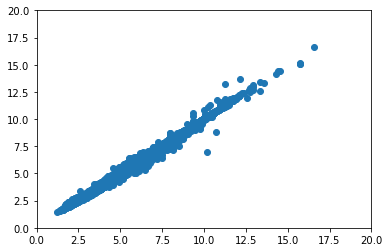

In [101]:
"""
sanity check - make sure new submission isn't too different with last submission
"""
baselinePred = np.load('{}/y_pred_pcqm4m.npz'.format("models/ensembling-gin-virtual-multipleDiffpool-bayesLastLayer-0.12960967032421664"))['y_pred']

import matplotlib.pyplot as plt

plt.scatter(baselinePred, ensemble_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

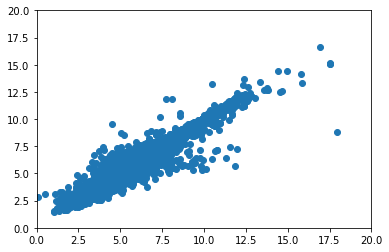

In [102]:
"""
sanity check - make sure new submission isn't too different with last submission
"""
baselinePred = np.load('models/gin-virtual/test/y_pred_pcqm4m.npz')['y_pred']

import matplotlib.pyplot as plt

plt.scatter(baselinePred, ensemble_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.show()

# uncertainty analysis for bestPairs

0.1293283019265724
             error  std_pred
error     1.000000  0.505837
std_pred  0.505837  1.000000


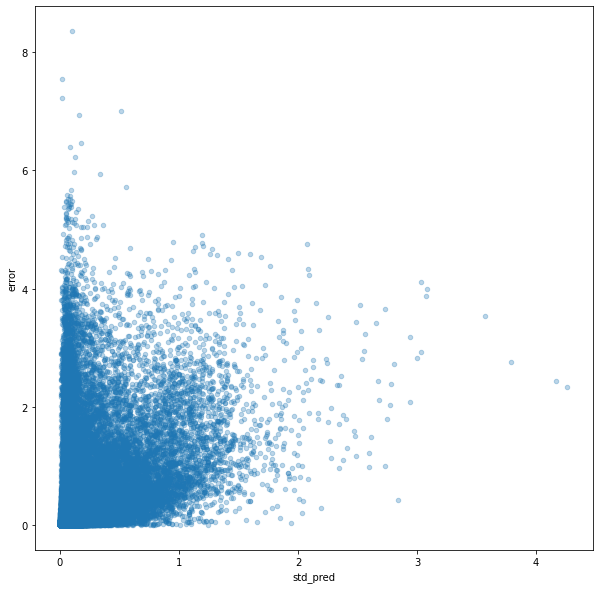

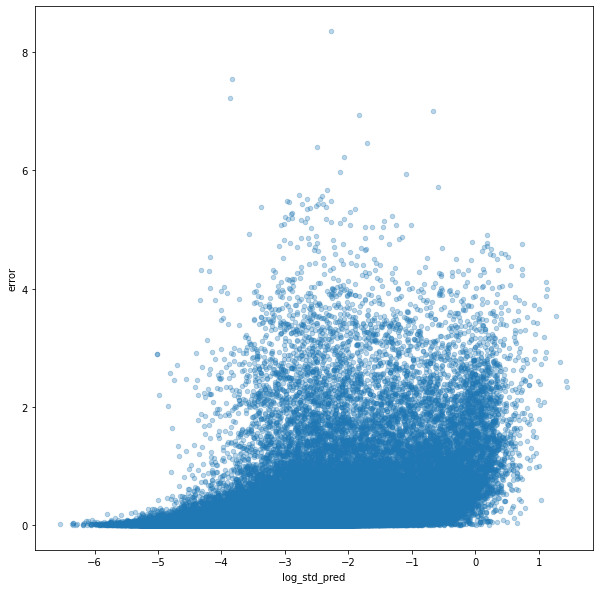

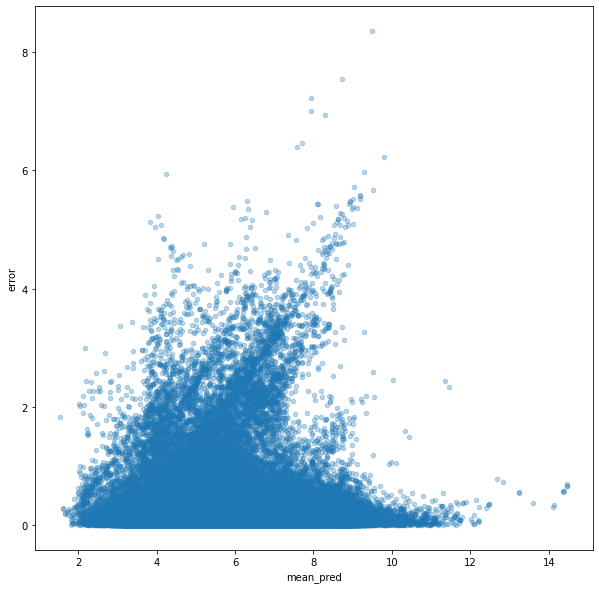

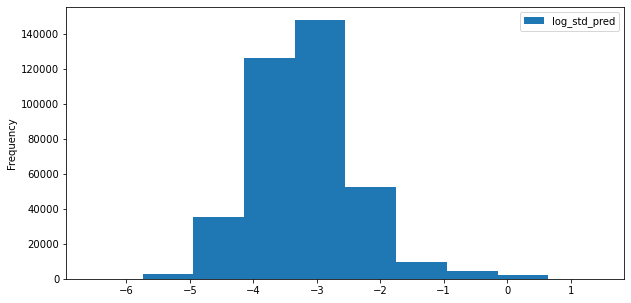

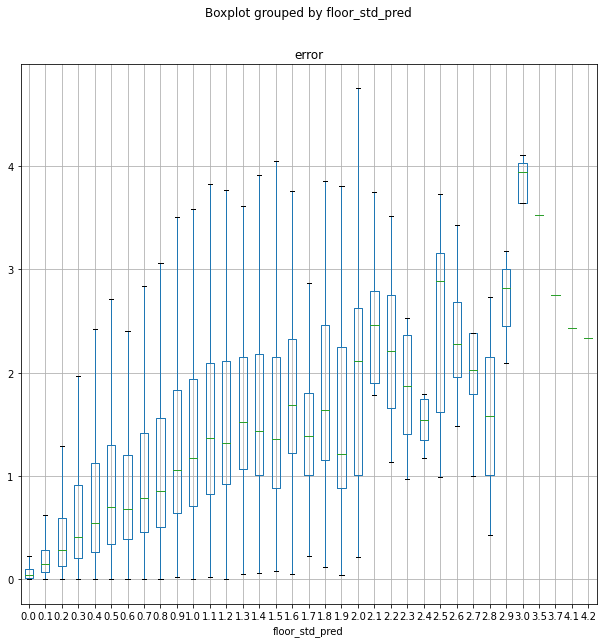

In [103]:
resultDF = pd.DataFrame(zip(*bestPairsVal), columns=bestPairsName)
resultDF["molecule_idx"] = ginDF["molecule_idx"]
resultDF["label"] = ginDF["label"]

# get mean prediction of ensemble
resultDF["mean_pred"] = resultDF[bestPairsName].mean(axis=1)

# get uncertainty
resultDF["std_pred"] = resultDF[bestPairsName].std(axis=1)
resultDF["log_std_pred"] = np.log(resultDF["std_pred"])

# get error
resultDF["error"] = abs(resultDF["mean_pred"] - resultDF["label"])

# floored uncertainty
resultDF["floor_std_pred"] = resultDF["std_pred"].apply(lambda x: int(x*10)/10)

# print error
input_dict = {"y_true": torch.tensor(resultDF["label"]), "y_pred": torch.tensor(resultDF["mean_pred"])}
mae = evaluator.eval(input_dict)["mae"]
print(mae)

# print correlation
print(resultDF[["error", "std_pred"]].corr())

# analyse uncertainty vs error
# uncertainty vs error
resultDF.plot.scatter("std_pred", "error", figsize=(10, 10), alpha=0.3)
# uncertainty vs error
resultDF.plot.scatter("log_std_pred", "error", figsize=(10, 10), alpha=0.3)
# mean-pred vs error
resultDF.plot.scatter("mean_pred", "error", figsize=(10, 10), alpha=0.3)
# histogram of uncertainty distribution
resultDF[["log_std_pred"]].plot.hist(figsize=(10, 5))
# plot boxplot of error
resultDF.boxplot(column="error", by="floor_std_pred", showfliers=False, figsize=(10, 10))

# save result to csv
resultDF.to_csv("{}/valid-pred-results.csv".format(args.save_test_dir))

0.12908956011159403
             error  std_pred
error     1.000000  0.507496
std_pred  0.507496  1.000000


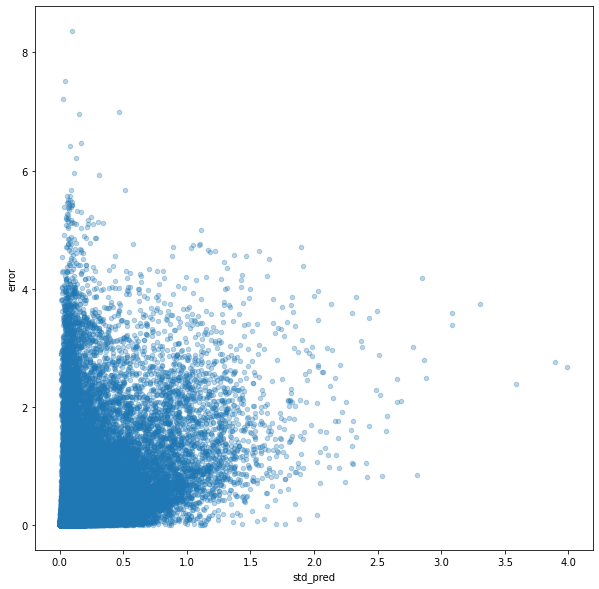

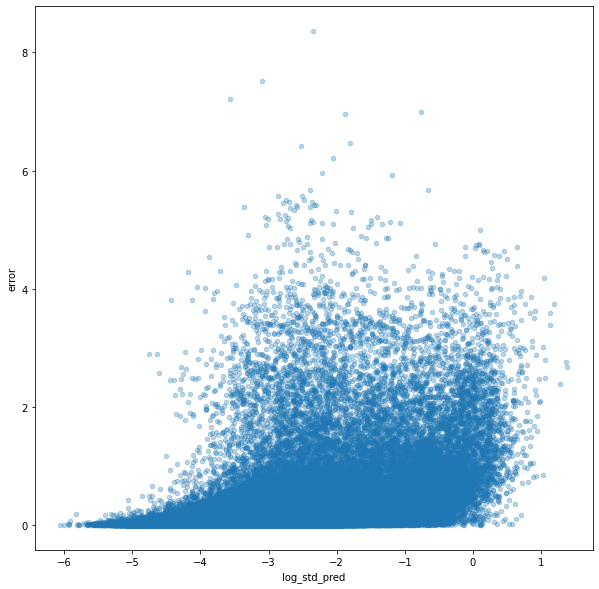

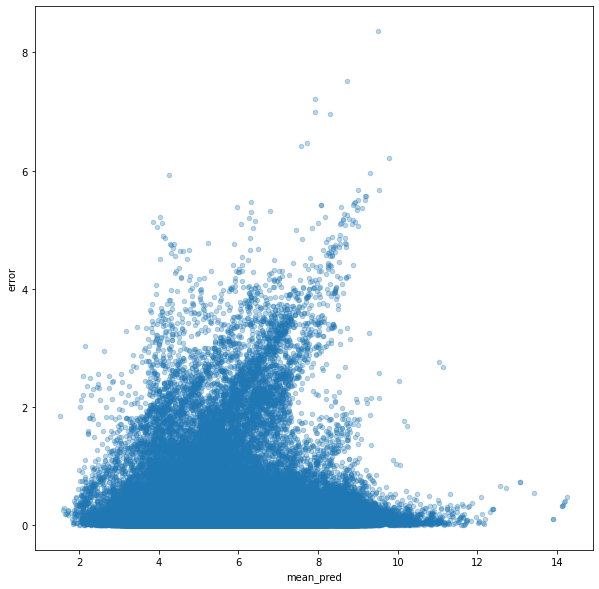

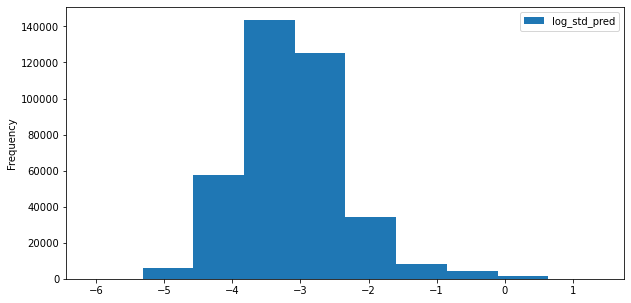

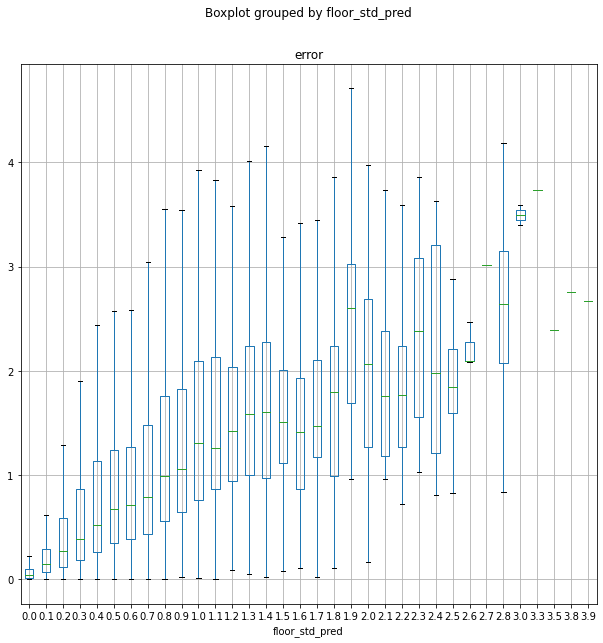

# debug

ensemble of similar models

In [27]:
# original score
[(dictVals[k][0], calcMAE([k], dictVals, label)) for k in dictVals.keys()]

[('gin-virtual', 0.14212890514945842),
 ('gin-virtual-run2', 0.14319078960547282),
 ('gin-virtual-run3', 0.15115169209323445),
 ('gin-virtual-bnn-lastLayer', 0.1405603771671842),
 ('gin-virtual-bnn-lastLayer-run2', 0.14188284104638627),
 ('gin-virtual-diffpool', 0.1370588209054448),
 ('gin-virtual-diffpool-run2', 0.13730227082210703),
 ('gin-virtual-diffpool-run3', 0.1373865085519866),
 ('gin-virtual-diffpool-8', 0.137526172366248),
 ('gin-virtual-diffpool-kamil', 0.1440623969280037)]

In [105]:
# get raw time series
# pairIndex = [1, 2, 4, 5, 6, 7, 8, 9, 10]
pairIndex = [1, 2, 4, 5, 6, 7, 8, 9]
pairs = [dictVals[x][1] for x in pairIndex]
pairName = [dictVals[x][0] for x in pairIndex]

mean_pred = np.mean(list(zip(*pairs)), axis=1)
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
score = evaluator.eval(input_dict)["mae"]

print(pairName, score)

['gin-virtual', 'gin-virtual-run2', 'gin-virtual-bnn-lastLayer', 'gin-virtual-bnn-lastLayer-run2', 'gin-virtual-diffpool', 'gin-virtual-diffpool-run2', 'gin-virtual-diffpool-run3', 'gin-virtual-diffpool-8'] 0.1293838589380646


In [36]:
# get raw time series
pairIndex = [1, 2, 3]
pairs = [dictVals[x][1] for x in pairIndex]
pairName = [dictVals[x][0] for x in pairIndex]

mean_pred = np.mean(list(zip(*pairs)), axis=1)
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
score = evaluator.eval(input_dict)["mae"]

print(pairName, score)

['gin-virtual', 'gin-virtual-run2', 'gin-virtual-run3'] 0.13605037454236693


In [30]:
# get raw time series
pairIndex = [4, 5]
pairs = [dictVals[x][1] for x in pairIndex]
pairName = [dictVals[x][0] for x in pairIndex]

mean_pred = np.mean(list(zip(*pairs)), axis=1)
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
score = evaluator.eval(input_dict)["mae"]

print(pairName, score)

['gin-virtual-bnn-lastLayer', 'gin-virtual-bnn-lastLayer-run2'] 0.13546409891037012


In [31]:
# get raw time series
pairIndex = [6, 7, 8]
pairs = [dictVals[x][1] for x in pairIndex]
pairName = [dictVals[x][0] for x in pairIndex]

mean_pred = np.mean(list(zip(*pairs)), axis=1)
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
score = evaluator.eval(input_dict)["mae"]

print(pairName, score)

['gin-virtual-diffpool', 'gin-virtual-diffpool-run2', 'gin-virtual-diffpool-run3'] 0.13461433445894994


# uncertainty analysis for ensemble of scores

In [68]:
def plotUncertaintyEnsemble(pairIndex):
    pairs = [dictVals[x][1] for x in pairIndex]
    pairsName = [dictVals[x][0] for x in pairIndex]

    resultDF = pd.DataFrame(zip(*pairs), columns=pairsName)
    resultDF["molecule_idx"] = ginDF["molecule_idx"]
    resultDF["label"] = ginDF["label"]

    # get mean prediction of ensemble
    resultDF["mean_pred"] = resultDF[pairsName].mean(axis=1)

    # get uncertainty
    resultDF["std_pred"] = resultDF[pairsName].std(axis=1)
    resultDF["log_std_pred"] = np.log(resultDF["std_pred"])

    # get error
    resultDF["error"] = abs(resultDF["mean_pred"] - resultDF["label"])

    # floored uncertainty
    resultDF["floor_std_pred"] = resultDF["std_pred"].apply(lambda x: int(x*10)/10)

    # print error
    input_dict = {"y_true": torch.tensor(resultDF["label"]), "y_pred": torch.tensor(resultDF["mean_pred"])}
    mae = evaluator.eval(input_dict)["mae"]
    print(mae)

    # print correlation
    print(resultDF[["error", "std_pred"]].corr())

    # analyse uncertainty vs error
    # uncertainty vs error
    resultDF.plot.scatter("std_pred", "error", figsize=(10, 10), alpha=0.3)
    # uncertainty vs error
    resultDF.plot.scatter("log_std_pred", "error", figsize=(10, 10), alpha=0.3)
    # mean-pred vs error
    resultDF.plot.scatter("mean_pred", "error", figsize=(10, 10), alpha=0.3)
    # plot boxplot of error
    resultDF.boxplot(column="error", by="floor_std_pred", showfliers=False, figsize=(10, 10))
    # histogram of uncertainty distribution
    resultDF[["log_std_pred"]].plot.hist(figsize=(10, 5))


0.13605037454236693
             error  std_pred
error     1.000000  0.498144
std_pred  0.498144  1.000000


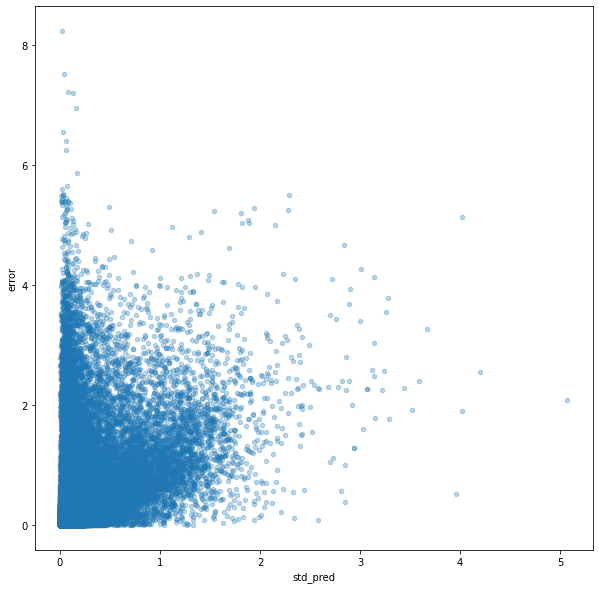

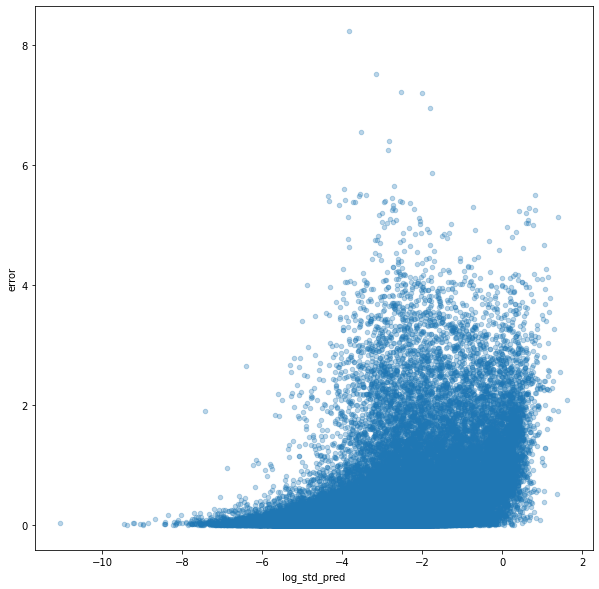

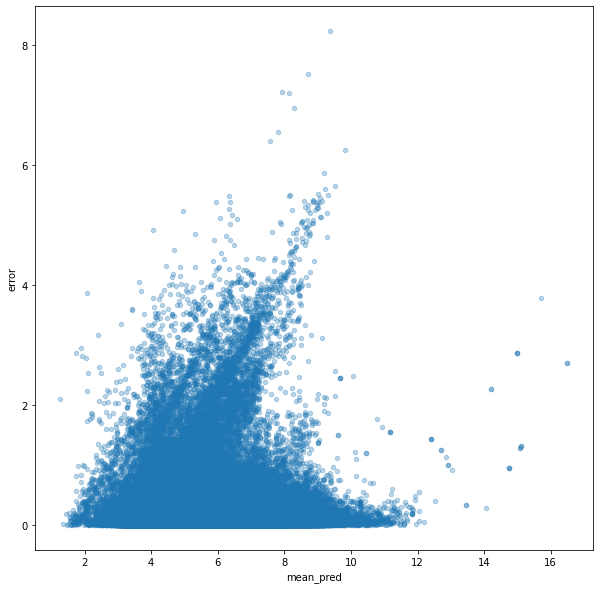

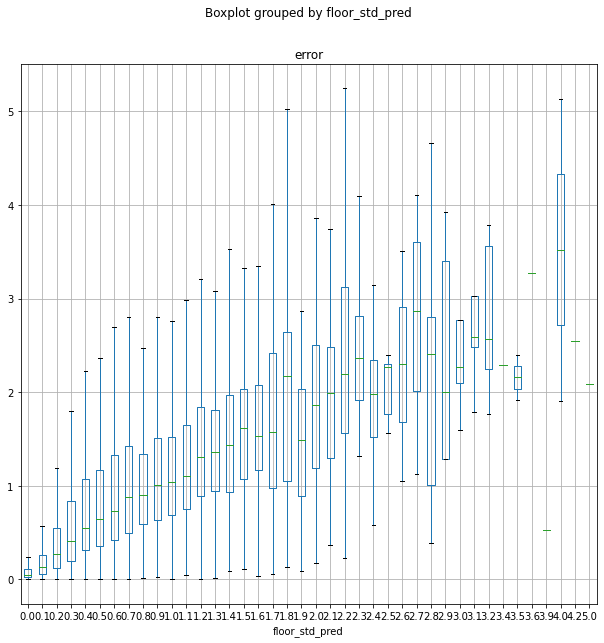

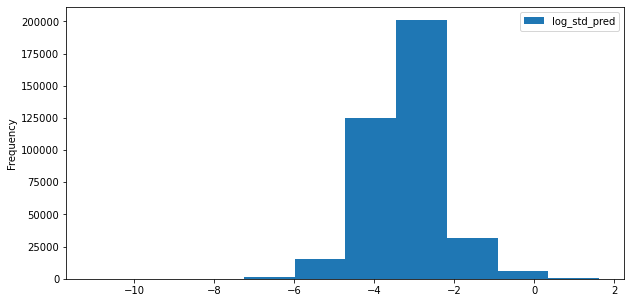

In [69]:
pairIndex = [1, 2, 3]
plotUncertaintyEnsemble(pairIndex)

C:\Users\eek31\AppData\Local\Continuum\anaconda3\envs\my-rdkit-env\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.13546409891037012
             error  std_pred
error     1.000000  0.323634
std_pred  0.323634  1.000000


ValueError: autodetected range of [-inf, 1.739204311937361] is not finite

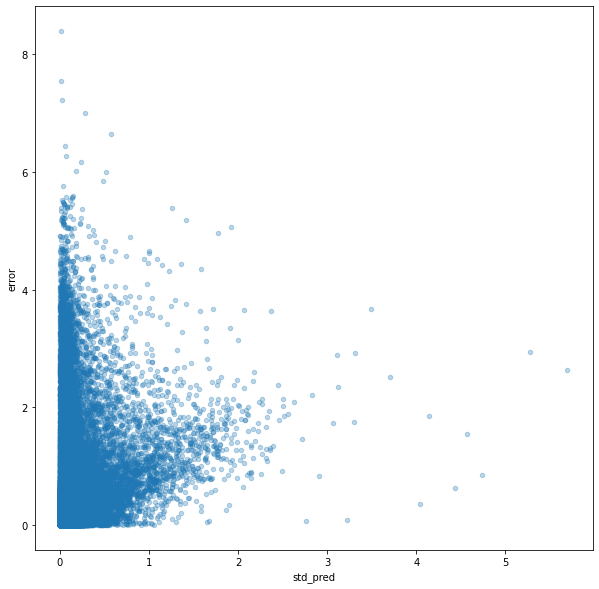

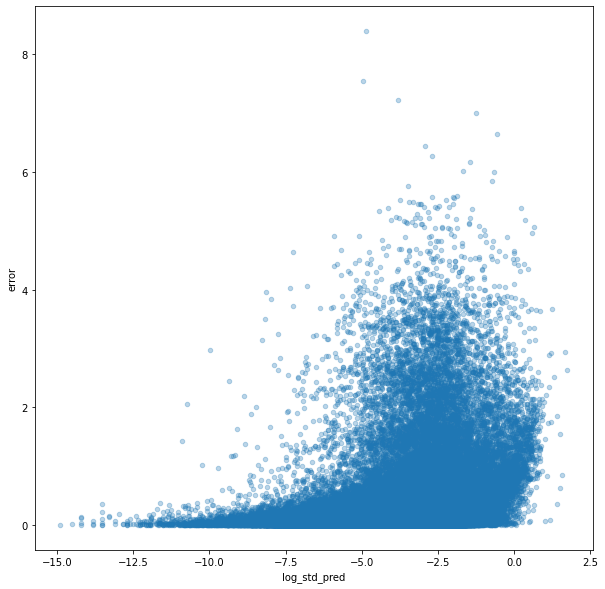

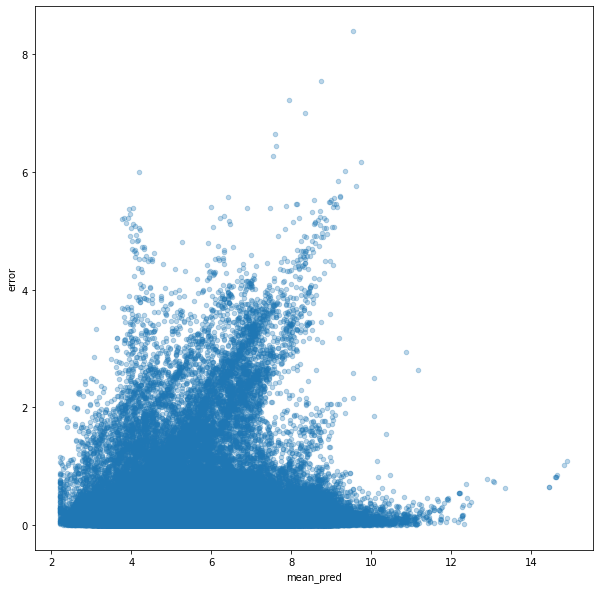

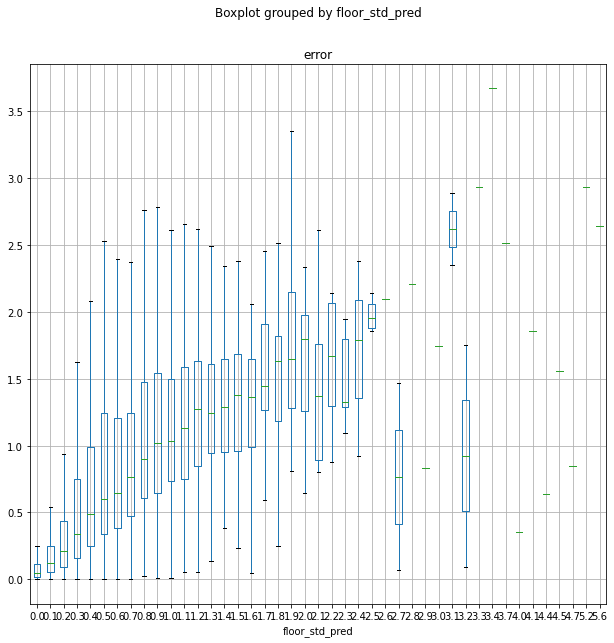

In [70]:
pairIndex = [4, 5]
plotUncertaintyEnsemble(pairIndex)

0.13461433445894994
             error  std_pred
error     1.000000  0.360371
std_pred  0.360371  1.000000


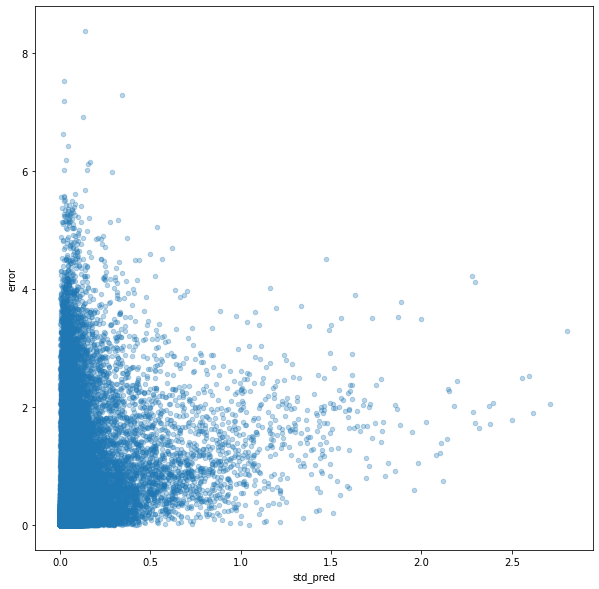

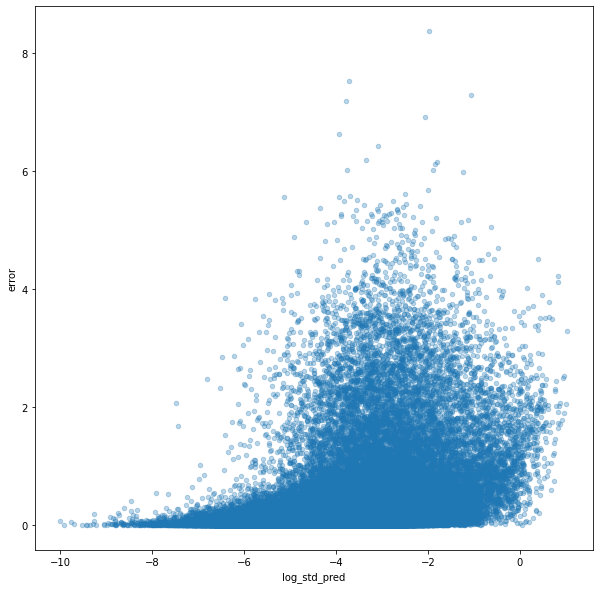

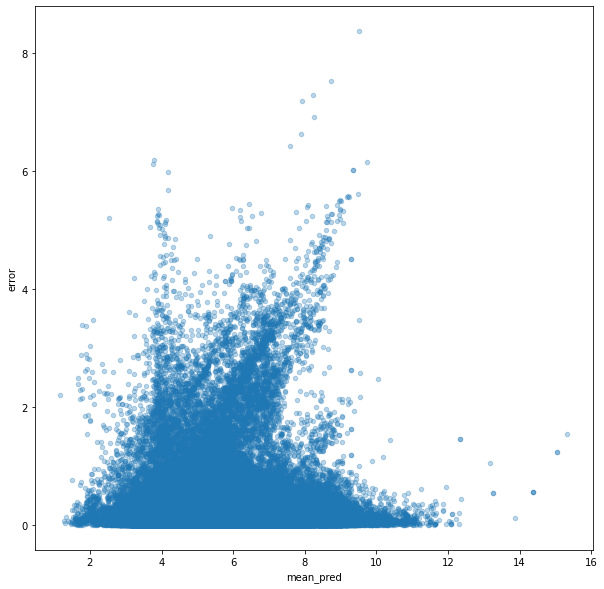

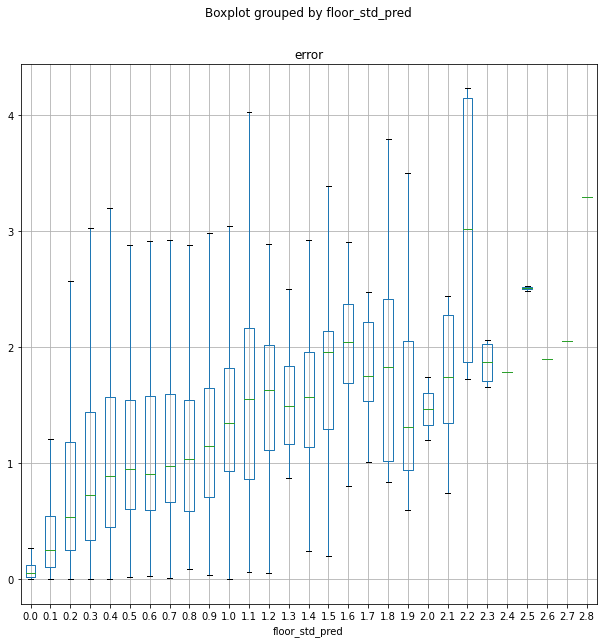

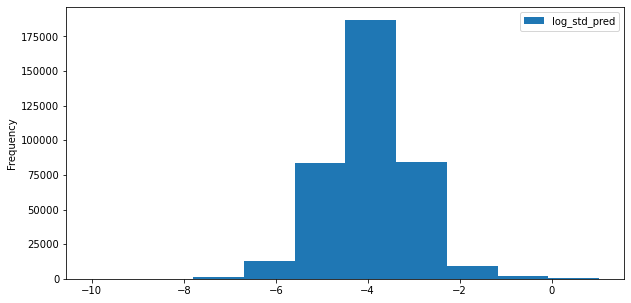

In [71]:
pairIndex = [6, 7, 8]
plotUncertaintyEnsemble(pairIndex)

0.1293838589380646
             error  std_pred
error     1.000000  0.511531
std_pred  0.511531  1.000000


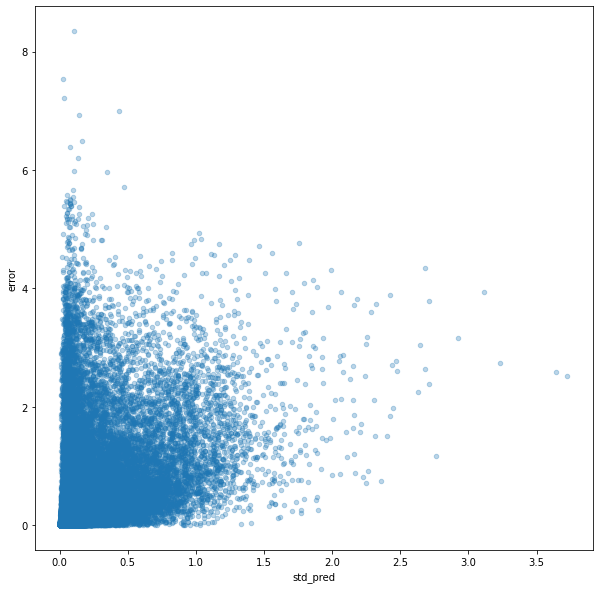

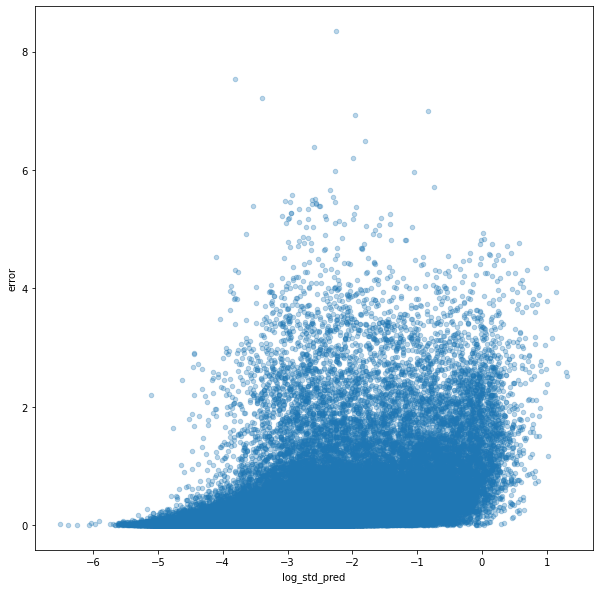

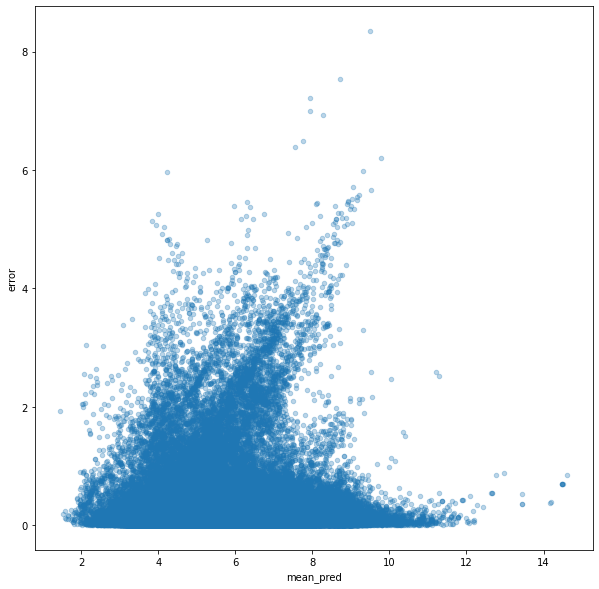

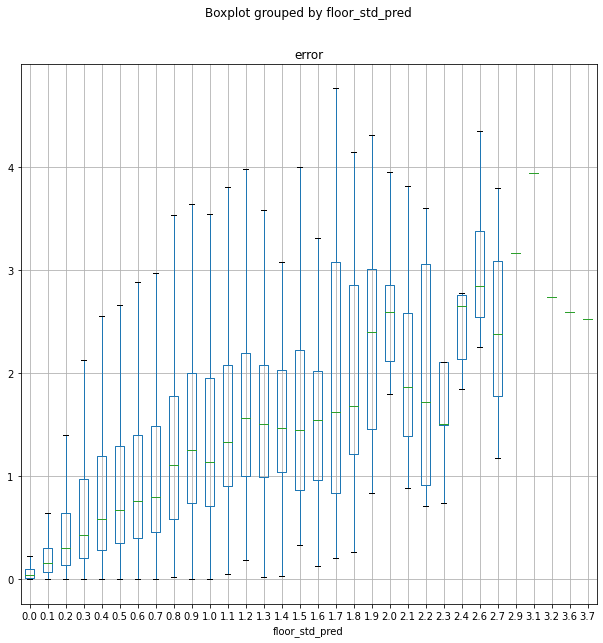

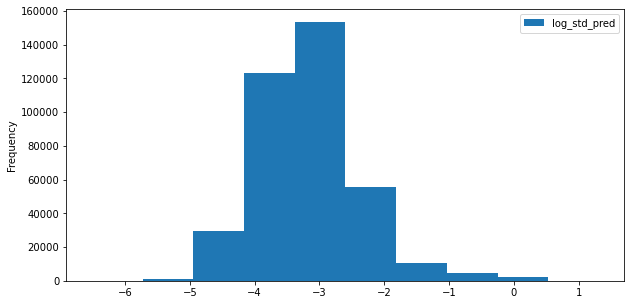

In [107]:
pairIndex = [1, 2, 4, 5, 6, 7, 8, 9]
plotUncertaintyEnsemble(pairIndex)

0.1304003360901791
             error  std_pred
error     1.000000  0.516047
std_pred  0.516047  1.000000


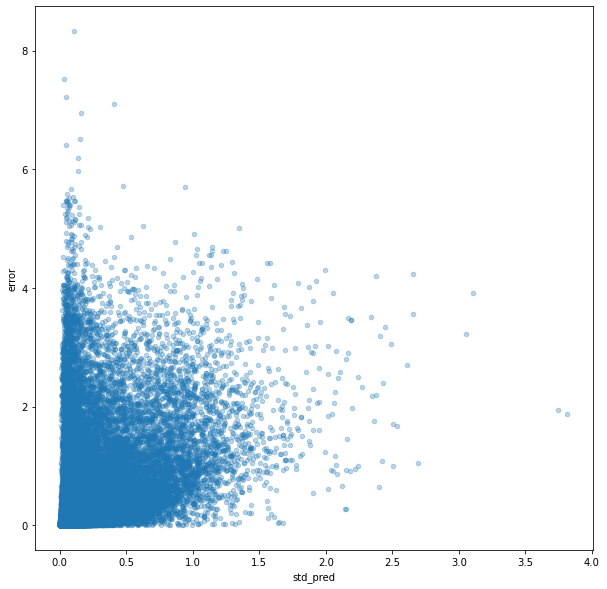

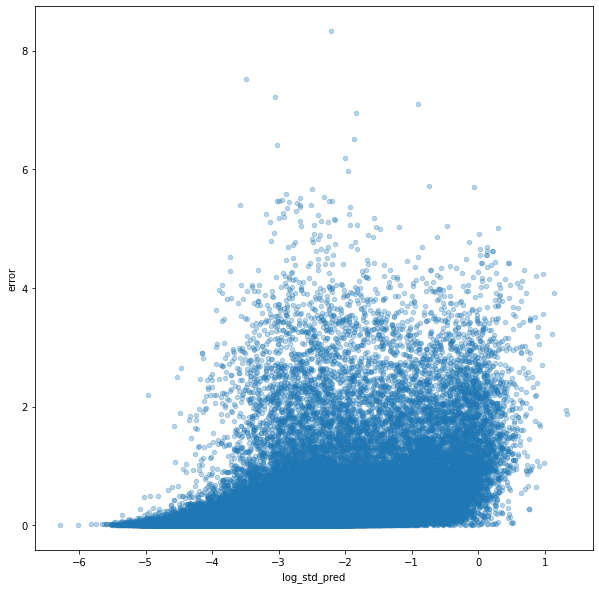

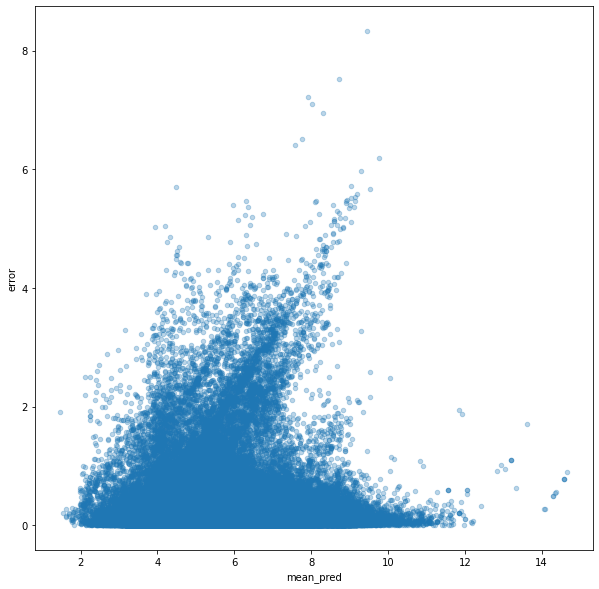

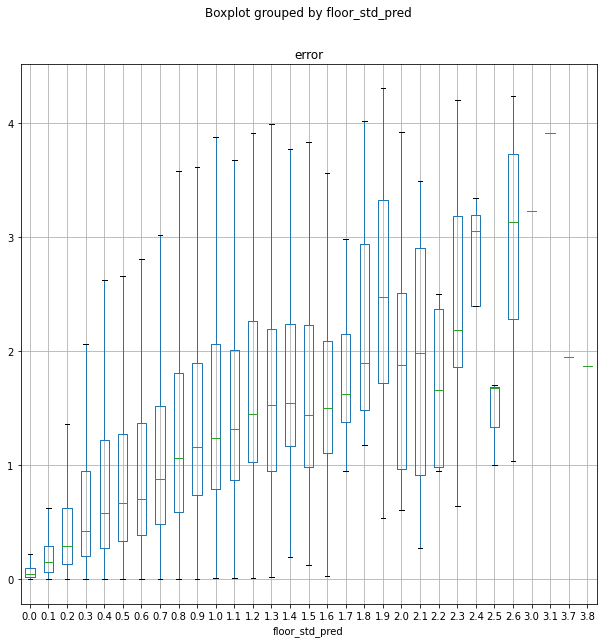

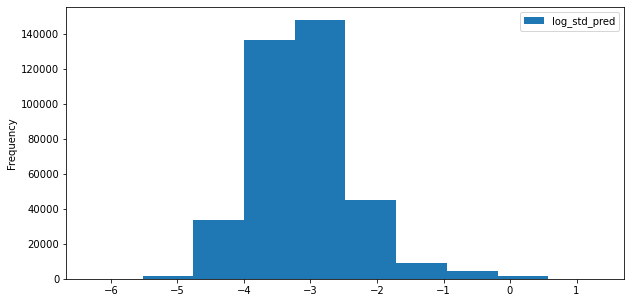

In [112]:
pairIndex = [1, 2, 3, 4, 5, 6, 7, 8]
plotUncertaintyEnsemble(pairIndex)

# plot ensemble effect

take only models that we consider

  0%|          | 0/3 [00:00<?, ?it/s]

,run_0,run_1,run_2,ensemble
gin-virtual,0.142129,0.143191,0.151152,0.136050
gin-virtual-bnn,0.140560,0.141883,0.000000,0.135464
gin-virtual-diffpool,0.137059,0.137302,0.137387,0.134614
ensemble-all,0.000000,0.000000,0.000000,0.130400


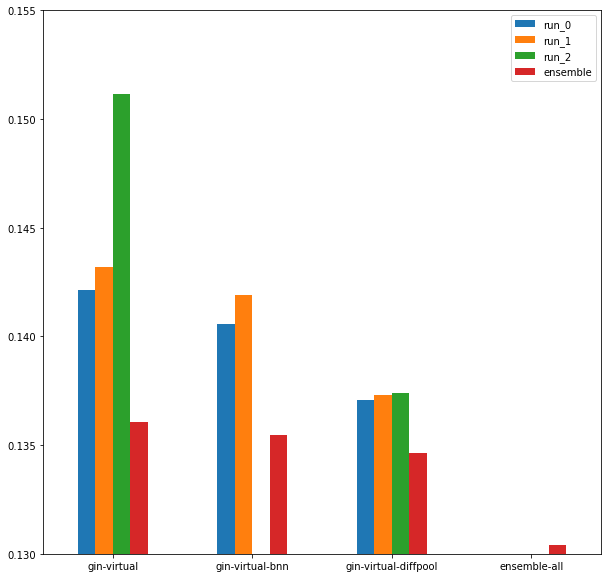

In [155]:
pairIndices = [
    ("gin-virtual", [1, 2, 3]),
    ("gin-virtual-bnn", [4, 5]),
    ("gin-virtual-diffpool", [6, 7, 8])
]
ensembleAllIndex = ("ensemble-all", [1, 2, 3, 4, 5, 6, 7, 8])

ensembleResults = []
ensembleNames = []
evaluator = PCQM4MEvaluator()
for modelName, pairIndex in tqdm(pairIndices):
    ensembleNames.append(modelName)
    
    ensembleResult = []
    # MC Runs
    for i in range(3):
        # get index
        if i < len(pairIndex):
            index = pairIndex[i]
            pred = dictVals[index][1]
            input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(pred)}
            score = evaluator.eval(input_dict)["mae"]
            ensembleResult.append(score)
        else:
            # no mode models
            ensembleResult.append(0)
    # ensemble mean
    pairs = [dictVals[x][1] for x in pairIndex]
    pairName = [dictVals[x][0] for x in pairIndex]
    mean_pred = np.mean(list(zip(*pairs)), axis=1)
    input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
    score = evaluator.eval(input_dict)["mae"]
    ensembleResult.append(score)
    
    ensembleResults.append(ensembleResult)
        
# append mean, ensemble of all
ensembleNames.append(ensembleAllIndex[0])
pairs = [dictVals[x][1] for x in ensembleAllIndex[1]]
mean_pred = np.mean(list(zip(*pairs)), axis=1)
input_dict = {"y_true": torch.tensor(label), "y_pred": torch.tensor(mean_pred)}
score = evaluator.eval(input_dict)["mae"]
ensembleResults.append([0, 0, 0, score])
        
ensembleResultsDF = pd.DataFrame(ensembleResults, columns=["run_0", "run_1", "run_2", "ensemble"])
ensembleResultsDF.index = ensembleNames
# plot
ensembleResultsDF.plot.bar(rot=0, figsize=(10, 10))
plt.ylim(0.13, 0.155)
ensembleResultsDF

# publication

- instead of stddev try range (lower than 30 data points statistics)
- box plot for uncertainty vs error